Clustering progress: 100%|██████████████████████| 40/40 [02:30<00:00,  3.75s/it]


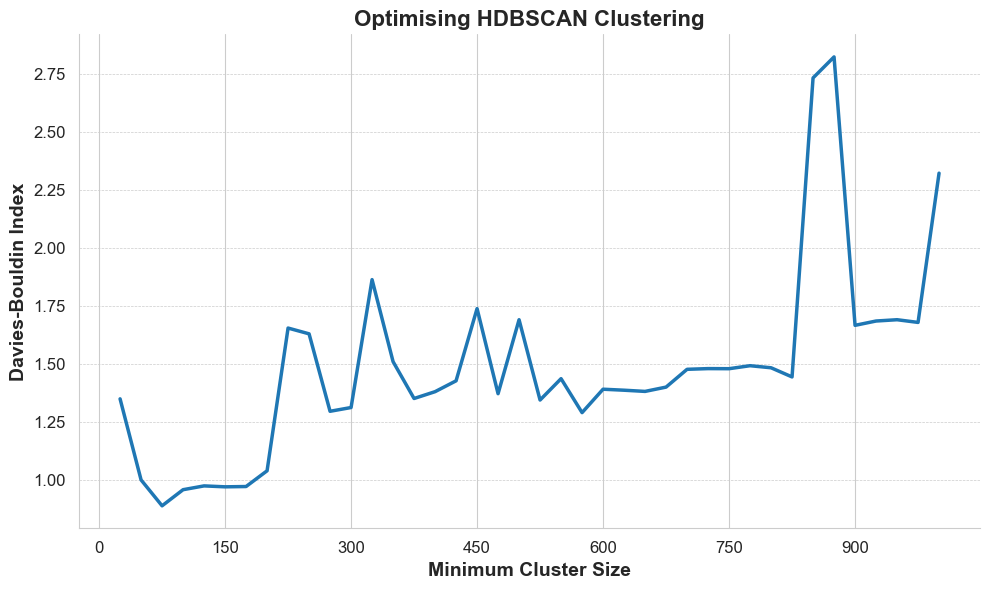

Optimal min_cluster_size: 75


/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_9652/345169267.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import hdbscan
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import davies_bouldin_score
from matplotlib.ticker import MaxNLocator

# import and read data
stars = '/Users/kobibrown/Desktop/Distance_Ladder_Project/Converted_Star_Data.csv'
df_all = pd.read_csv(stars)

# Create a DataFrame with local stars using parallax and assign them to cluster -1
df_local_stars = df_all[df_all['Parallax'] > 0.007].copy()
df_local_stars['cluster'] = -1

# filter out local stars using parallax
df = df_all[df_all['Parallax'] <= 0.005]

# use Equatorial and Polar coordinates for clustering
X = df[['Equat', 'Polar']]

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# define function to evaluate clustering quality using Davies-Bouldin index
def evaluate_clustering(X_scaled, data, min_cluster_size):
    # perform clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusters = clusterer.fit_predict(X_scaled)

    # calculate Davies-Bouldin index for current clustering
    davies_bouldin_index = davies_bouldin_score(X_scaled, clusters)

    # return Davies-Bouldin index
    return davies_bouldin_index

# set range of values for min_cluster_size to try
min_cluster_sizes = range(25, 1001, 25)

# initialize array to store Davies-Bouldin indices for each min_cluster_size value
davies_bouldin_indices = np.zeros(len(min_cluster_sizes))

# loop over each value of min_cluster_size and evaluate clustering quality
progress_bar = tqdm(min_cluster_sizes, desc='Clustering progress')
for i, min_cluster_size in enumerate(progress_bar):
    davies_bouldin_index = evaluate_clustering(X_scaled, df, min_cluster_size)
    davies_bouldin_indices[i] = davies_bouldin_index
    
# plot results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(min_cluster_sizes, davies_bouldin_indices, linewidth=2.5, color='tab:blue')

# customize plot appearance
ax.set_xlabel('Minimum Cluster Size', fontsize=14, fontweight='bold')
ax.set_ylabel('Davies-Bouldin Index', fontsize=14, fontweight='bold')
ax.set_title('Optimising HDBSCAN Clustering', fontsize=16, fontweight='bold')

# set x-axis tick formatting
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# set spines and ticks style
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='both', length=6, width=2, labelsize=12)

# add grid lines
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
    
# choose optimal value for min_cluster_size based on results
optimal_min_cluster_size = min_cluster_sizes[np.argmin(davies_bouldin_indices)]
print(f"Optimal min_cluster_size: {optimal_min_cluster_size}")

# perform clustering with optimal min_cluster_size
clusters = hdbscan.HDBSCAN(min_cluster_size=optimal_min_cluster_size).fit_predict(X_scaled)

# make cluster column and sort stars into their clusters
df['cluster'] = clusters
df_final = pd.concat([df, df_local_stars], axis=0, ignore_index=True)

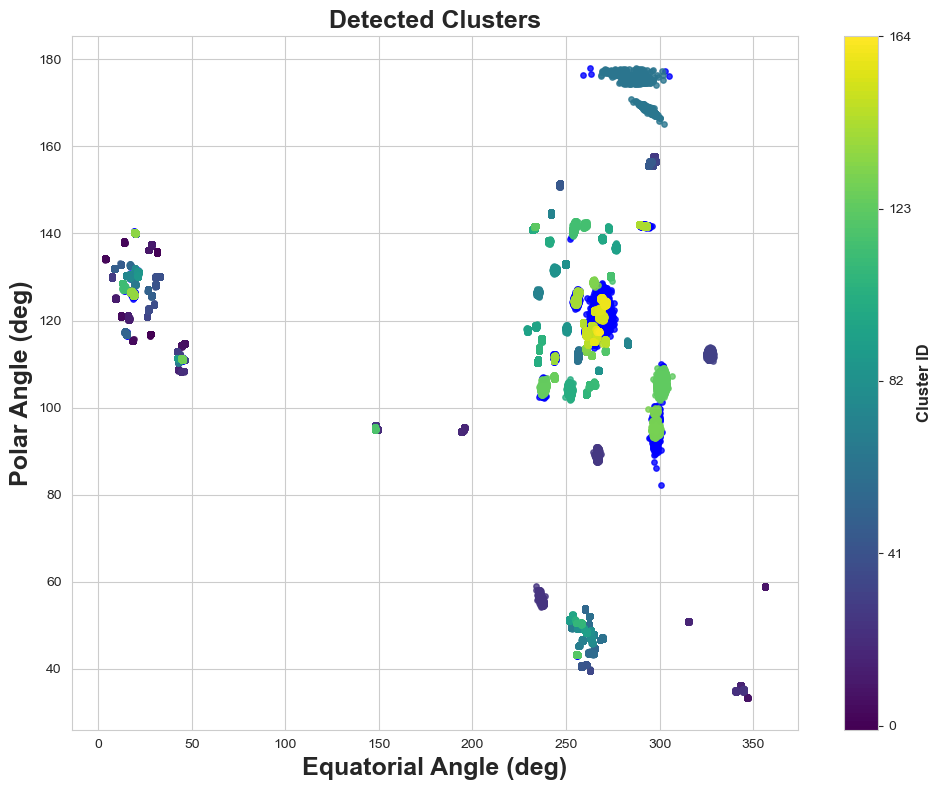

In [91]:
# plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('viridis', len(df['cluster'].unique()))

# add points for each cluster
for cluster in sorted(df['cluster'].unique()):
    if cluster == -1:
        color = 'blue'
    else:
        color = cmap(cluster)

    plt.scatter(df.loc[df['cluster'] == cluster, 'Equat'], df.loc[df['cluster'] == cluster, 'Polar'],
                color=color, alpha=0.8, s=15, zorder=1)

# add axis labels and title
plt.xlabel('Equatorial Angle (deg)', fontsize=18, fontweight='bold')
plt.ylabel('Polar Angle (deg)', fontsize=18, fontweight='bold')
plt.title('Detected Clusters', fontsize=18, fontweight='bold')

# Create color map legend
norm = plt.Normalize(vmin=df['cluster'].min(), vmax=df['cluster'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ticks=np.linspace(df['cluster'].min()+1, df['cluster'].max(), 5))
cbar.set_label('Cluster ID', fontsize='large', fontweight='bold')

plt.tight_layout()
plt.savefig('clusters.png', dpi=300)

Number of clusters: 165


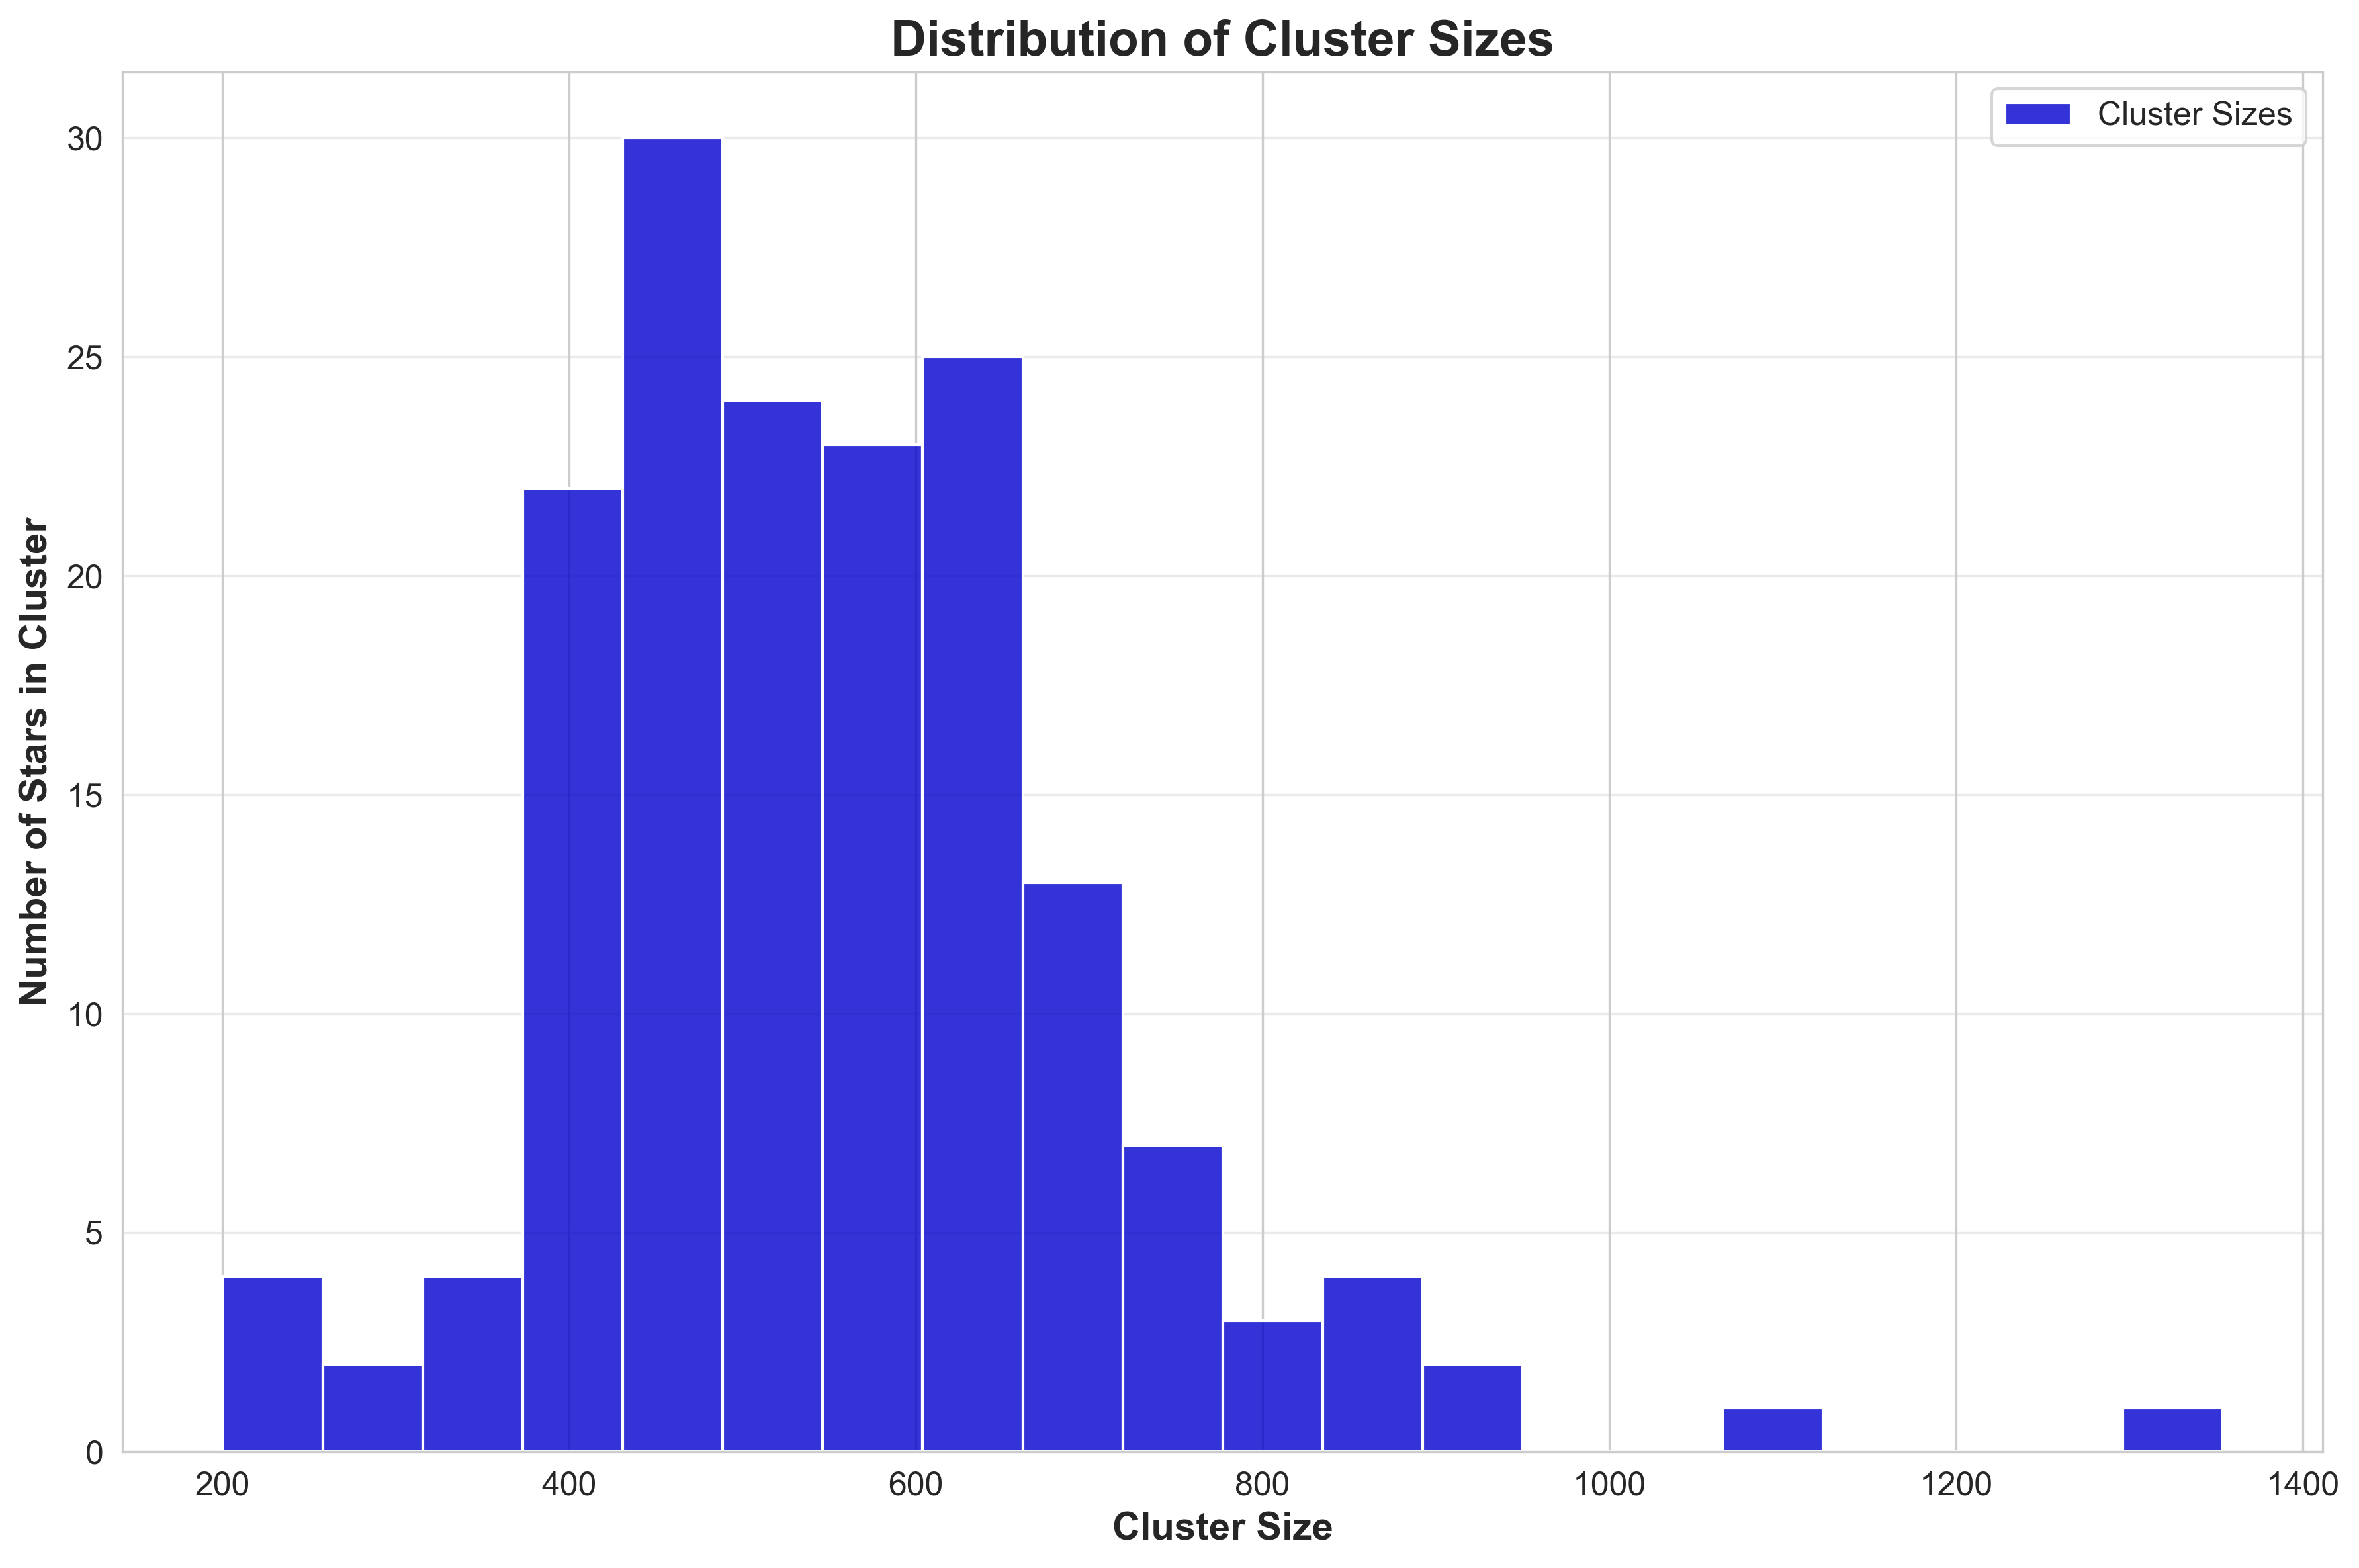

In [93]:
# filter out noise points (-1 label)
df_clusters = df[df['cluster'] != -1]

# number of clusters and their sizes
num_clusters = len(df_clusters['cluster'].unique())
print(f'Number of clusters: {num_clusters}')
cluster_sizes = df_clusters['cluster'].value_counts().sort_values(ascending=False)

# plot the data
plt.figure(figsize=(12, 8), dpi=300)
sns.set_style('whitegrid')
ax = sns.histplot(cluster_sizes, bins=20, kde=False, color='mediumblue', alpha=0.8)

# set title and axis labels
ax.set_title('Distribution of Cluster Sizes', fontsize=18, fontweight='bold')
ax.set_xlabel('Cluster Size', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Stars in Cluster', fontsize=14, fontweight='bold')

# set tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', bottom=False)

# add grid lines and legend
ax.grid(axis='y', alpha=0.4)
plt.legend(['Cluster Sizes'], fontsize=12)

# save and show the plot
plt.tight_layout()
plt.savefig('cluster_sizes.png')
plt.show()

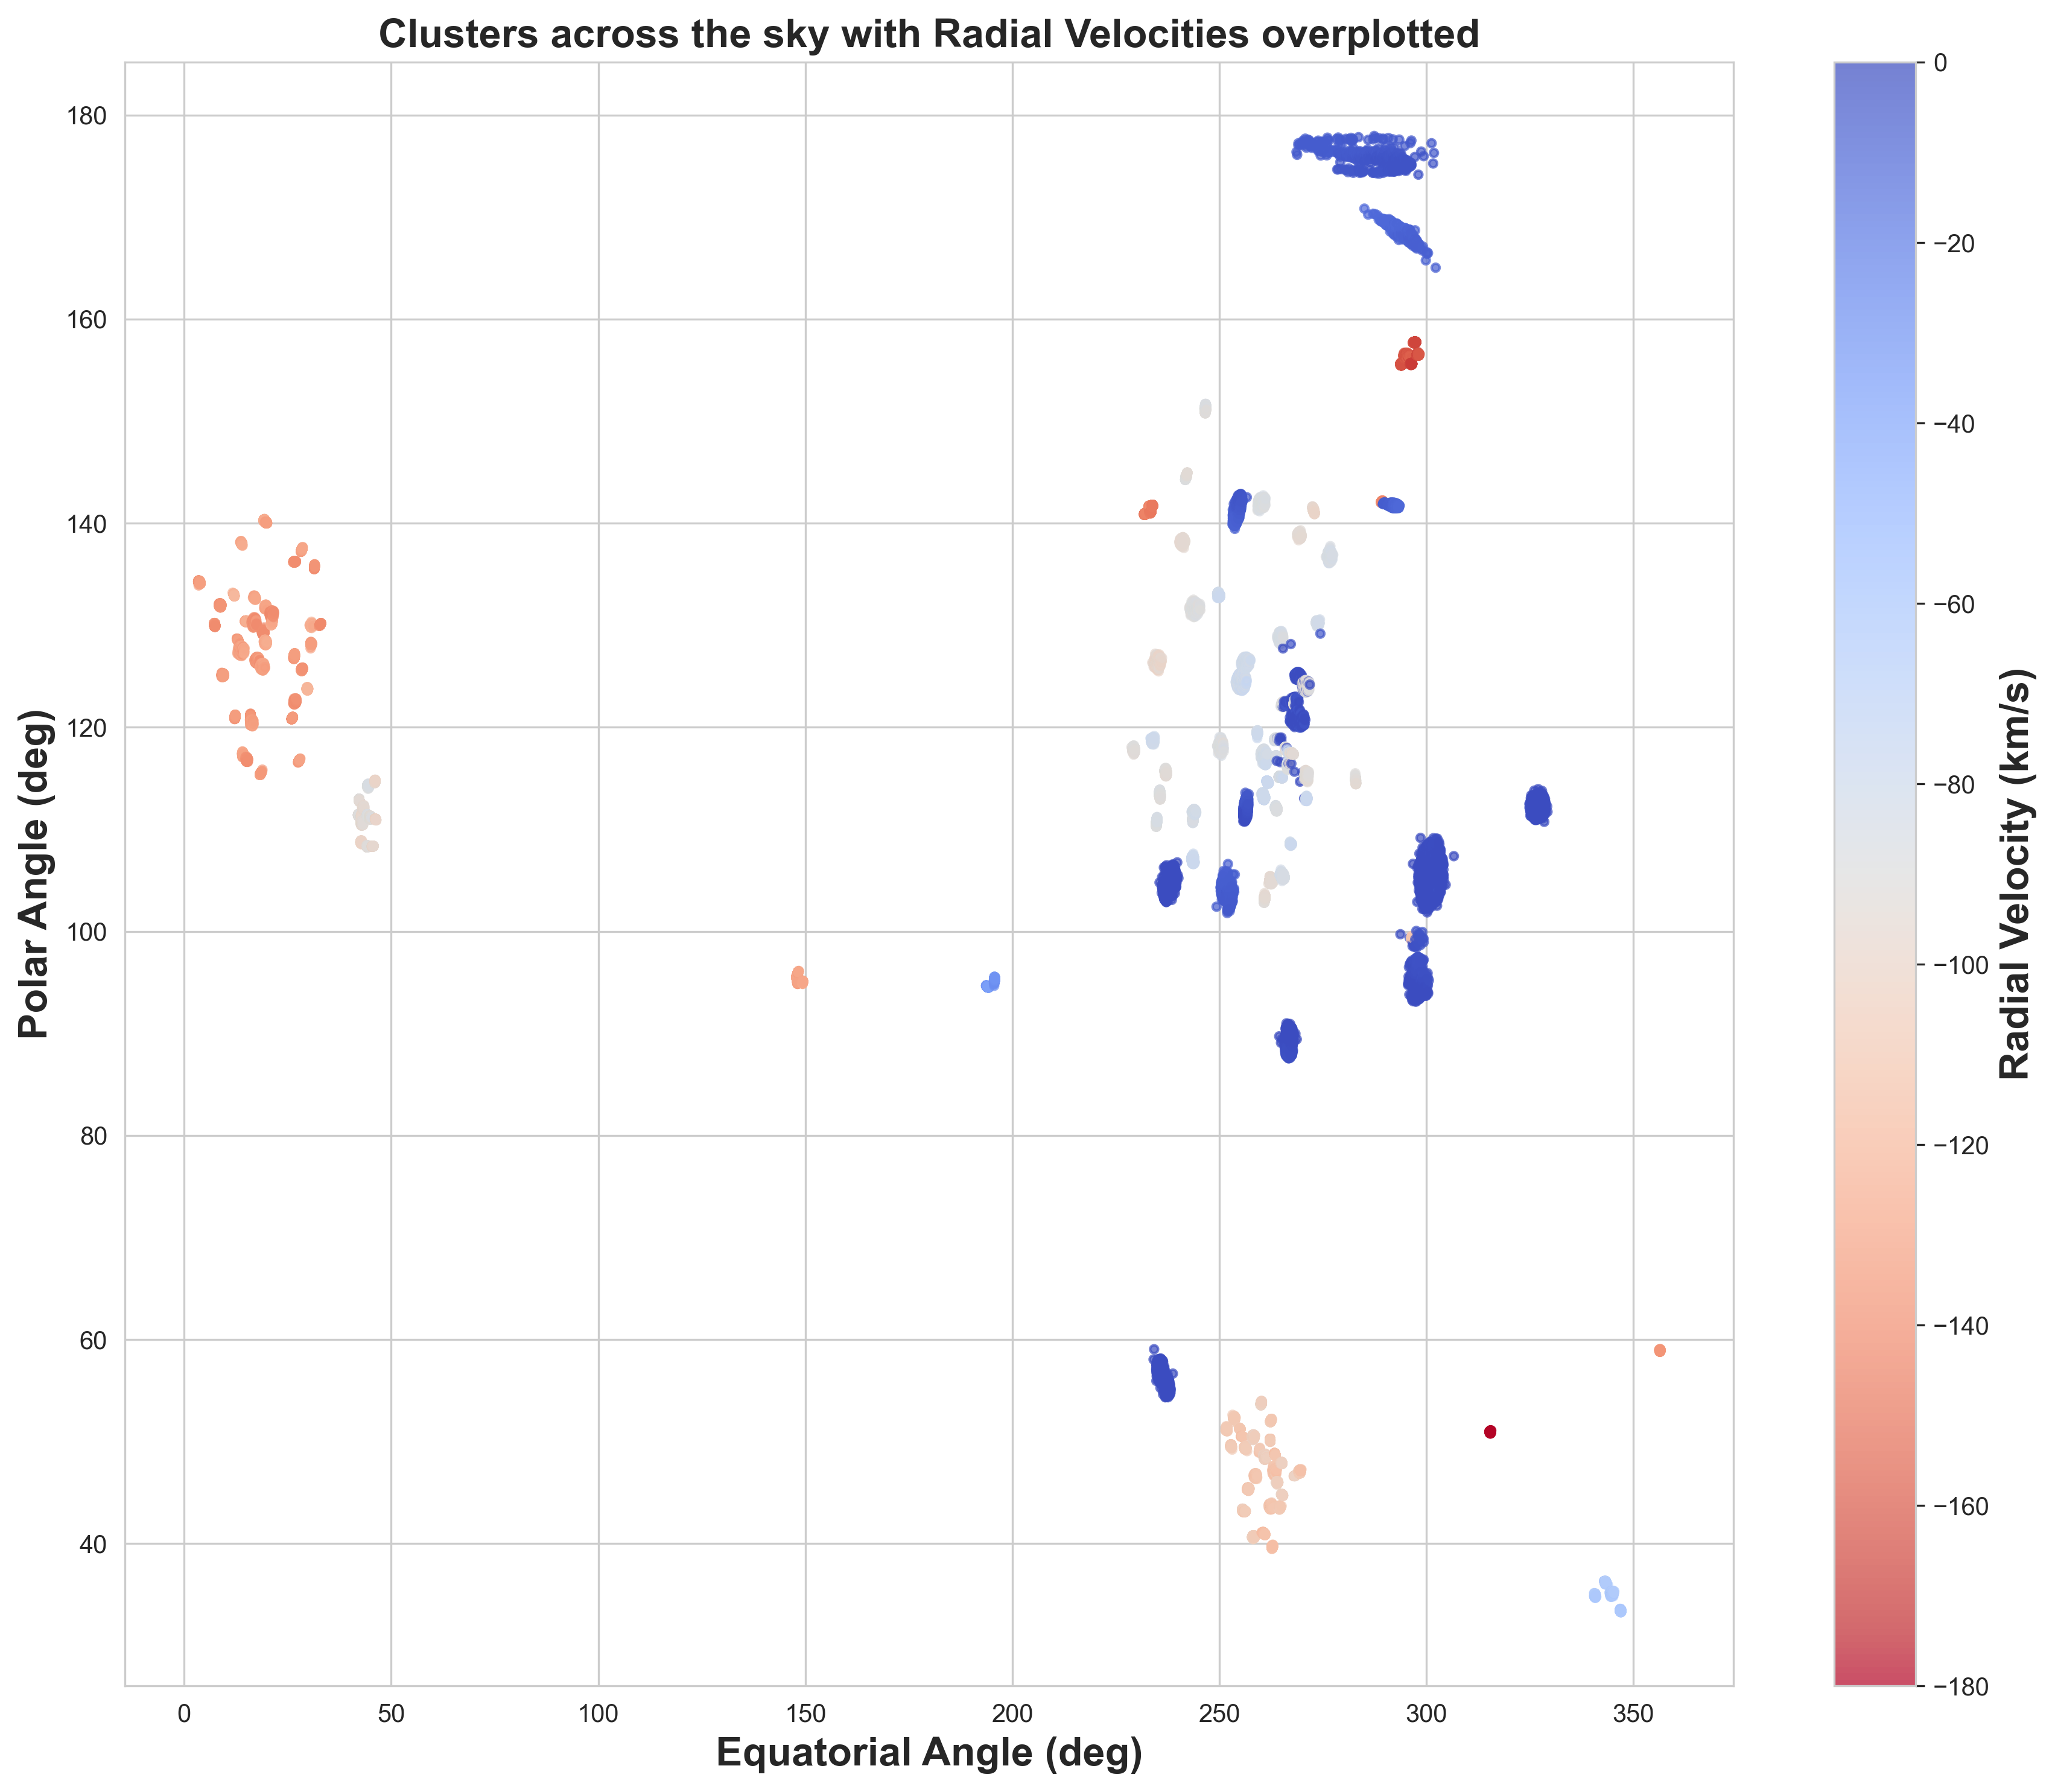

In [96]:
# radial velocity visualisation
plt.figure(figsize=(12, 10), dpi=300)
scatter = plt.scatter(data=df_clusters, x='Equat', y='Polar', c='RadialVelocity', cmap='coolwarm_r', s=10, alpha=0.7)

# add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Radial Velocity (km/s)', fontsize=16, fontweight='bold')

plt.xlabel('Equatorial Angle (deg)', fontsize=16, fontweight='bold')
plt.ylabel('Polar Angle (deg)', fontsize=16, fontweight='bold')
plt.title('Clusters across the sky with Radial Velocities overplotted', fontsize=16, fontweight='bold')

# set red color for positive radial velocities
scatter.set_clim(vmin=-180, vmax=0)

plt.tight_layout()
plt.show()


In [89]:
# Define the output file path
output_file_path = '/Users/kobibrown/Desktop/Distance_Ladder_Project/clustered_star_data.csv'

# Export the DataFrame with cluster information to a CSV file
df_final.to_csv(output_file_path, index=False)

In [90]:
# Calculate the number of stars in each cluster
cluster_counts = df.groupby('cluster').size()

# Print the number of stars in each cluster
print("Number of stars in each cluster:")
for cluster, count in cluster_counts.items():
    if cluster == -1:
        label = "Local galaxy (cluster -1)"
    else:
        label = f"Cluster {cluster}"
    print(f"{label}: {count} stars")

Number of stars in each cluster:
Local galaxy (cluster -1): 3992 stars
Cluster 0: 609 stars
Cluster 1: 466 stars
Cluster 2: 606 stars
Cluster 3: 638 stars
Cluster 4: 590 stars
Cluster 5: 512 stars
Cluster 6: 608 stars
Cluster 7: 846 stars
Cluster 8: 529 stars
Cluster 9: 315 stars
Cluster 10: 582 stars
Cluster 11: 578 stars
Cluster 12: 505 stars
Cluster 13: 426 stars
Cluster 14: 673 stars
Cluster 15: 496 stars
Cluster 16: 914 stars
Cluster 17: 369 stars
Cluster 18: 571 stars
Cluster 19: 653 stars
Cluster 20: 463 stars
Cluster 21: 587 stars
Cluster 22: 367 stars
Cluster 23: 405 stars
Cluster 24: 426 stars
Cluster 25: 637 stars
Cluster 26: 429 stars
Cluster 27: 708 stars
Cluster 28: 674 stars
Cluster 29: 836 stars
Cluster 30: 449 stars
Cluster 31: 458 stars
Cluster 32: 746 stars
Cluster 33: 806 stars
Cluster 34: 484 stars
Cluster 35: 584 stars
Cluster 36: 492 stars
Cluster 37: 538 stars
Cluster 38: 416 stars
Cluster 39: 432 stars
Cluster 40: 379 stars
Cluster 41: 459 stars
Cluster 42: 467